In [1]:

import concurrent.futures
import requests
import zipfile
import os
!pip install wget
import wget

link_train="https://zenodo.org/records/5706578/files/Train.zip?download=1"
link_val="https://zenodo.org/records/5706578/files/Val.zip?download=1"
link_test="https://zenodo.org/records/5706578/files/Test.zip?download=1"


def download_and_extract(url, destination):
  """Downloads a zip file from a URL and extracts it to a destination directory.

  Args:
    url: The URL of the zip file.
    destination: The directory to extract the zip file to.
  """

  # Download the zip file
  wget.download(url, out=destination+".zip")

  # Extract the zip file
  with zipfile.ZipFile(destination+".zip", 'r') as zip_ref:
    zip_ref.extractall(destination)

  print(f"Downloaded and extracted {url} to {destination}")

# Download and extract the train, validation, and test datasets in parallel
with concurrent.futures.ThreadPoolExecutor() as executor:
    futures = [
        executor.submit(download_and_extract, link_train, 'Train'),
        executor.submit(download_and_extract, link_val, 'Val'),
        executor.submit(download_and_extract, link_test, 'Test')
    ]

    # Wait for all downloads and extractions to complete
    concurrent.futures.wait(futures)




  Preparing metadata (setup.py) ... done
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9656 sha256=5a9ef206d7859ebca7c296e91c9b9093cda082cda4bbbcce71409017955a7123
  Stored in directory: /root/.cache/pip/wheels/8b/f1/7f/5c94f0a7a505ca1c81cd1d9208ae2064675d97582078e6c769
Successfully built wget
Downloaded and extracted https://zenodo.org/records/5706578/files/Val.zip?download=1 to Val
Downloaded and extracted https://zenodo.org/records/5706578/files/Test.zip?download=1 to Test
Downloaded and extracted https://zenodo.org/records/5706578/files/Train.zip?download=1 to Train


In [2]:
!pip install segmentation-models-pytorch
!pip install timm
!pip install ptflops

# Import necessary libraries
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split
import torchvision.transforms as transforms
import segmentation_models_pytorch as smp
from collections import OrderedDict
from tqdm import tqdm
from ptflops import get_model_complexity_info
import segmentation_models_pytorch.utils


image_dir = os.path.join("./Train" ,"Train", "Rural", "images_png")
mask_dir = os.path.join("./Train" ,"Train", "Rural", "masks_png")

image_dir_val = os.path.join("./Val" ,"Val", "Rural", "images_png")
mask_dir_val = os.path.join("./Val" ,"Val", "Rural", "masks_png")


  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 6.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.3/121.3 kB 3.7 MB/s eta 0:00:00
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16424 sha256=0ba861046a3c25b23544fb78df902aaa4af8b970ffabcb0367eb7f0ae3166419
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60944 sha256=15f2e853f49593f7fe641c181e65d4580c190b0207cc8a35831935ff2a913ad9
  Stored in directory: /root/.cache/pip/wheels/35/cb/a5/8f534c60142835bfc889f9a482e4a67e0b817032d9c6883b64
Successfully built efficientnet-pytorch pretrainedmodels


In [4]:


# Example grayscale values
COLOR_MAP = {
    'class1': 0.00392157,
    'class2': 0.00784314,
    'class3': 0.01176471,
    'class4': 0.01568628,
    'class5': 0.01960784,
    'class6': 0.02352941,
    'class7': 0.02745098
}

# Map class names to indices
LABEL_MAP = {k: v for v, k in enumerate(COLOR_MAP.keys())}

# Tolerance-based color to label conversion
def color_to_one_hot(mask, label_map, tolerance=0.001, num_classes=7):
    """
    Converts a grayscale mask to a one-hot encoded mask based on a color map and tolerance.

    Args:
        mask (np.ndarray): The input grayscale mask.
        label_map (dict): A dictionary mapping class names to label indices.
        tolerance (float): The tolerance for matching grayscale values.
        num_classes (int): Number of classes (channels).

    Returns:
        torch.Tensor: The one-hot encoded mask.
    """
    mask = np.asarray(mask, dtype=np.float32)
    one_hot_mask = np.zeros((num_classes, mask.shape[1], mask.shape[2]), dtype=np.float32)

    for class_name, class_index in label_map.items():
        color_value = COLOR_MAP[class_name]
        # Match pixels with the grayscale value within the tolerance
        matches = np.abs(mask - color_value) < tolerance
        # print(class_index, np.squeeze(matches, axis=0))
        one_hot_mask[class_index, np.squeeze(matches, axis=0)] = 1.0

    return torch.from_numpy(one_hot_mask)


# Dataset class
class LoveDADataset(Dataset):
    def __init__(self, image_dir, mask_dir, image_transform=None, mask_transform=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.image_transform = image_transform
        self.mask_transform = mask_transform
        self.images = os.listdir(image_dir)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_name = os.path.join(self.image_dir, self.images[idx])
        mask_name = os.path.join(self.mask_dir, self.images[idx])
        image = Image.open(img_name).convert("RGB")
        mask = Image.open(mask_name).convert("L")
        if self.image_transform:
            image = self.image_transform(image)
        if self.mask_transform:
            mask = self.mask_transform(mask)
        return image, mask

# Transforms
image_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
mask_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Lambda(lambda mask: color_to_one_hot(mask, LABEL_MAP)),
])

# Dataset and DataLoaders
train_dataset = LoveDADataset(image_dir, mask_dir, image_transform, mask_transform)
val_dataset = LoveDADataset(image_dir_val, mask_dir_val, image_transform, mask_transform)

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=1, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False, num_workers=1, pin_memory=True)

# Model definition

# image, mask = dataset[13]
# print(f"Image shape: {image.shape}")
# print(f"Mask shape: {mask.shape}")


# plt.imshow(image.permute(1, 2, 0))
# plt.show()

# fig, axes = plt.subplots(1, 7, figsize=(20, 5))

# # Itera attraverso i canali della maschera (7 classi)
# for i in range(7):
#     # Estrai il canale i-esimo
#     mask_class = mask[i].cpu().numpy()  # Converti in array numpy per la visualizzazione

#     # Visualizza la maschera della classe i
#     axes[i].imshow(mask_class, cmap='jet')  # Usa una mappa di colori (ad esempio, 'jet')
#     axes[i].set_title(f'Class {i + 1}')
#     axes[i].axis('off')  # Disabilita gli assi

# Mostra il risultato
plt.tight_layout()
plt.show()


<Figure size 640x480 with 0 Axes>

In [5]:
!pip install torchmetrics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 927.3/927.3 kB 43.5 MB/s eta 0:00:00


In [6]:
#deeplabv2
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import models, transforms
from torch.utils.data import Dataset, DataLoader
from torchmetrics import JaccardIndex
# from numba import cuda


import numpy as np
import cv2
from tqdm import tqdm
from skimage.io import imread
from skimage.transform import resize
import os
from PIL import Image

# --- Model Definition ---
class DeepLabV2(nn.Module):
    def __init__(self, num_classes):
        super(DeepLabV2, self).__init__()
        # Load the pre-trained ResNet-101 backbone
        resnet = models.resnet101(weights=models.ResNet101_Weights.IMAGENET1K_V1)

        # Remove the fully connected layer of ResNet-101
        self.backbone = nn.Sequential(*list(resnet.children())[:-2])

        # ASPP (Atrous Spatial Pyramid Pooling) module
        self.aspp = nn.Sequential(
            ASPP(2048, [6, 12, 18, 24], 256),  # Output channels are 256
            nn.Conv2d(256, num_classes, kernel_size=1)
        )

    def forward(self, x):
        # x = F.interpolate(x, scale_factor=2, mode='bilinear', align_corners=True)
        x = self.backbone(x)
        x = self.aspp(x)
        x = F.interpolate(x, scale_factor=32, mode='bilinear', align_corners=True)

        return x

class ASPP(nn.Module):
    def __init__(self, in_channels, atrous_rates, out_channels):
        super(ASPP, self).__init__()
        modules = []
        modules.append(nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU()))

        for rate in atrous_rates:
            modules.append(ASPPConv(in_channels, out_channels, rate))

        self.convs = nn.ModuleList(modules)

        self.project = nn.Sequential(
            nn.Conv2d(len(self.convs) * out_channels, out_channels, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            nn.Dropout(0.5)
        )

    def forward(self, x):
        res = []
        for conv in self.convs:
            res.append(conv(x))
        res = torch.cat(res, dim=1)
        return self.project(res)

class ASPPConv(nn.Sequential):
    def __init__(self, in_channels, out_channels, dilation):
        modules = [
            nn.Conv2d(in_channels, out_channels, 3, padding=dilation, dilation=dilation, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU()
        ]
        super(ASPPConv, self).__init__(*modules)


# --- Training (Optional) ---
def train(model, train_loader, criterion, optimizer, device, num_epochs=10):
    model.train()
    for epoch in range(num_epochs):
        running_loss = 0.0
        for images, masks in tqdm(train_loader):
            images = images.to(device)
            masks = masks.to(device)

            optimizer.zero_grad()
            outputs = model(images)

            # print(f"Output shape: {outputs.shape}")
            # print(f"Mask shape: {masks.shape}")
            # print(f"Images shape: {images.shape}")


            loss = criterion(outputs, masks)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * images.size(0)

        epoch_loss = running_loss / len(train_loader.dataset)
        print(f'Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}')
        miou = evaluate(model, val_loader, device, NUM_CLASSES)
        print(f'mIoU: {np.mean(miou):.4f}')

def evaluate(model, data_loader, device, num_classes):
    model.eval()
    total_iou = []
    val_loss = 0.0
    intersection = torch.zeros(num_classes).to(device)
    union = torch.zeros(num_classes).to(device)
    with torch.no_grad():
        for images, masks in tqdm(data_loader):
            images = images.to(device)
            masks = masks.to(device)
            outputs = model(images)

            loss = criterion(outputs, masks)
            val_loss += loss.item()
            # _, preds = torch.max(outputs, dim=1)
            preds = outputs.argmax(dim=1).detach()  # Detach to prevent GPU memory buildup
            masks = masks.argmax(dim=1).detach()
            for i in range(num_classes):
                intersection[i] += torch.sum((preds == i) & (masks == i)).float()
                union[i] += torch.sum((preds == i) | (masks == i)).float()

            # Free GPU memory
            del outputs, preds, masks,images
            torch.cuda.empty_cache()

    avg_val_loss = val_loss / len(data_loader)
    print(f"Validation Loss: {avg_val_loss:.4f}")

    # Calculate mIoU
    IoU = intersection / (union + 1e-6)  # Avoid division by zero
    # mIoU = IoU.mean()
    return IoU.data.cpu().numpy()

# --- Main ---
if __name__ == "__main__":
    # Hyperparameters
    NUM_CLASSES = 7  # Example: Pascal VOC has 21 classes (including background)
    BATCH_SIZE = 4
    LEARNING_RATE = 0.00009
    NUM_EPOCHS = 20

    # Device
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Model
    model = DeepLabV2(num_classes=NUM_CLASSES).to(device)


    # Loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

    train(model, train_loader, criterion, optimizer, device, num_epochs=NUM_EPOCHS)
    # Training (optional)
    iou = evaluate(model, val_loader, device, NUM_CLASSES)
    # Evaluation
    print(f'IoU: {(iou)}')
    print(f'mean IoU: {np.mean(iou)}')



    # Save the model (optional)
    torch.save(model.state_dict(), 'deeplabv2_resnet101.pth')


Downloading: "https://download.pytorch.org/models/resnet101-63fe2227.pth" to /root/.cache/torch/hub/checkpoints/resnet101-63fe2227.pth
100%|██████████| 171M/171M [00:02<00:00, 74.1MB/s]
100%|██████████| 342/342 [02:03<00:00,  2.76it/s]


Epoch 1/20, Loss: 1.1091


100%|██████████| 248/248 [01:17<00:00,  3.22it/s]


Validation Loss: 1.0445
mIoU: 0.2983


100%|██████████| 342/342 [01:54<00:00,  3.00it/s]


Epoch 2/20, Loss: 0.9136


100%|██████████| 248/248 [01:14<00:00,  3.31it/s]


Validation Loss: 1.1196
mIoU: 0.2925


100%|██████████| 342/342 [01:55<00:00,  2.97it/s]


Epoch 3/20, Loss: 0.8146


100%|██████████| 248/248 [01:14<00:00,  3.31it/s]


Validation Loss: 1.1494
mIoU: 0.2972


100%|██████████| 342/342 [01:53<00:00,  3.02it/s]


Epoch 4/20, Loss: 0.7552


100%|██████████| 248/248 [01:14<00:00,  3.34it/s]


Validation Loss: 1.0364
mIoU: 0.2907


100%|██████████| 342/342 [01:54<00:00,  2.99it/s]


Epoch 5/20, Loss: 0.7332


100%|██████████| 248/248 [01:14<00:00,  3.32it/s]


Validation Loss: 0.9608
mIoU: 0.3262


100%|██████████| 342/342 [01:54<00:00,  2.99it/s]


Epoch 6/20, Loss: 0.6734


100%|██████████| 248/248 [01:15<00:00,  3.30it/s]


Validation Loss: 1.0882
mIoU: 0.2992


100%|██████████| 342/342 [01:54<00:00,  2.98it/s]


Epoch 7/20, Loss: 0.6221


100%|██████████| 248/248 [01:15<00:00,  3.28it/s]


Validation Loss: 0.9884
mIoU: 0.2825


100%|██████████| 342/342 [01:54<00:00,  2.99it/s]


Epoch 8/20, Loss: 0.5988


100%|██████████| 248/248 [01:14<00:00,  3.31it/s]


Validation Loss: 1.2051
mIoU: 0.2986


100%|██████████| 342/342 [01:54<00:00,  2.98it/s]


Epoch 9/20, Loss: 0.5389


100%|██████████| 248/248 [01:15<00:00,  3.28it/s]


Validation Loss: 1.0816
mIoU: 0.3301


100%|██████████| 342/342 [01:54<00:00,  3.00it/s]


Epoch 10/20, Loss: 0.4960


100%|██████████| 248/248 [01:14<00:00,  3.31it/s]


Validation Loss: 1.0904
mIoU: 0.3177


100%|██████████| 342/342 [01:54<00:00,  2.99it/s]


Epoch 11/20, Loss: 0.4711


100%|██████████| 248/248 [01:14<00:00,  3.31it/s]


Validation Loss: 1.1218
mIoU: 0.3265


100%|██████████| 342/342 [01:54<00:00,  2.99it/s]


Epoch 12/20, Loss: 0.4646


100%|██████████| 248/248 [01:14<00:00,  3.32it/s]


Validation Loss: 1.3987
mIoU: 0.3023


100%|██████████| 342/342 [01:54<00:00,  2.99it/s]


Epoch 13/20, Loss: 0.4798


100%|██████████| 248/248 [01:15<00:00,  3.30it/s]


Validation Loss: 1.1696
mIoU: 0.2771


100%|██████████| 342/342 [01:53<00:00,  3.02it/s]


Epoch 14/20, Loss: 0.5750


100%|██████████| 248/248 [01:15<00:00,  3.30it/s]


Validation Loss: 1.1413
mIoU: 0.3115


100%|██████████| 342/342 [01:53<00:00,  3.02it/s]


Epoch 15/20, Loss: 0.4619


100%|██████████| 248/248 [01:16<00:00,  3.24it/s]


Validation Loss: 1.1382
mIoU: 0.3379


100%|██████████| 342/342 [01:53<00:00,  3.00it/s]


Epoch 16/20, Loss: 0.4179


100%|██████████| 248/248 [01:15<00:00,  3.27it/s]


Validation Loss: 1.2826
mIoU: 0.3227


100%|██████████| 342/342 [01:52<00:00,  3.05it/s]


Epoch 17/20, Loss: 0.4015


100%|██████████| 248/248 [01:15<00:00,  3.28it/s]


Validation Loss: 1.2293
mIoU: 0.3140


100%|██████████| 342/342 [01:53<00:00,  3.02it/s]


Epoch 18/20, Loss: 0.3974


100%|██████████| 248/248 [01:14<00:00,  3.32it/s]


Validation Loss: 1.2871
mIoU: 0.3285


100%|██████████| 342/342 [01:53<00:00,  3.01it/s]


Epoch 19/20, Loss: 0.3930


100%|██████████| 248/248 [01:14<00:00,  3.31it/s]


Validation Loss: 1.2861
mIoU: 0.3229


100%|██████████| 342/342 [01:54<00:00,  2.98it/s]


Epoch 20/20, Loss: 0.3887


100%|██████████| 248/248 [01:15<00:00,  3.30it/s]


Validation Loss: 1.3463
mIoU: 0.3218


100%|██████████| 248/248 [01:15<00:00,  3.29it/s]


Validation Loss: 1.3463
IoU: [0.48789158 0.24997048 0.08104881 0.5117013  0.0984676  0.23262875
 0.5907285 ]
mean IoU: 0.32177671790122986


Input Tensor:  torch.Size([1, 3, 256, 256])
Ground Truth:  torch.Size([7, 256, 256])
Model Output:  torch.Size([1, 7, 256, 256])


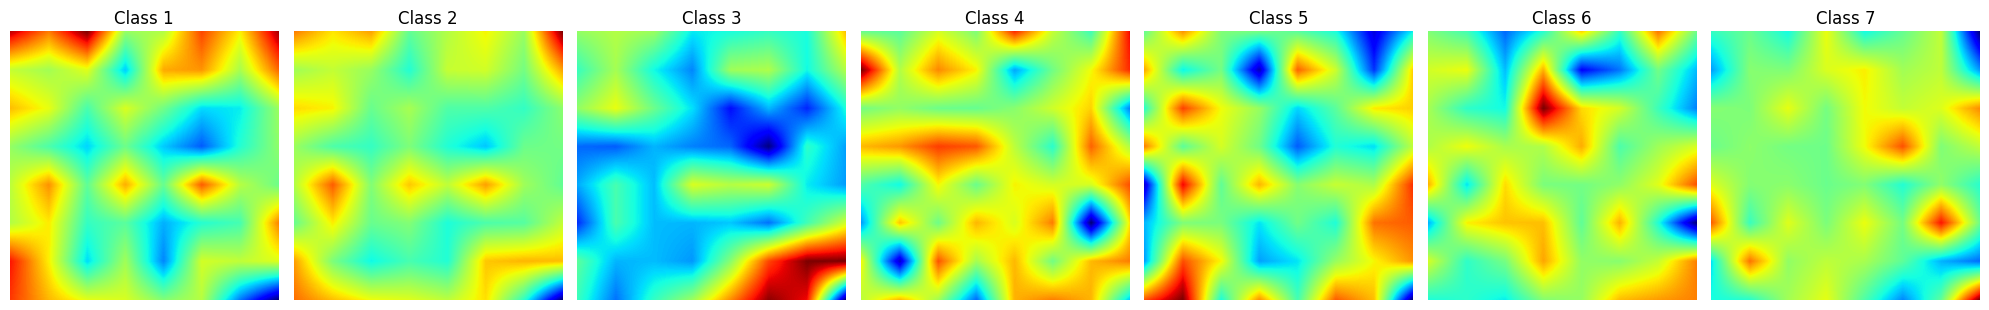

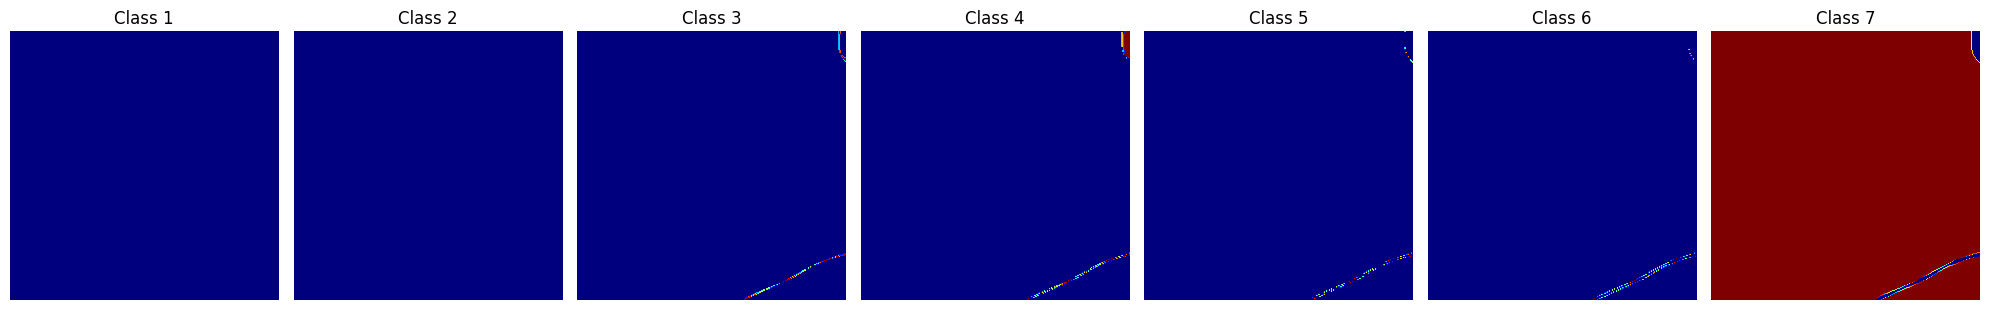

In [8]:
# Ensure the model is on the correct device (GPU or CPU)
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# model = model.to(device)  # Move model to the selected device
torch.cuda.empty_cache()
TRAINING=1
if TRAINING:  # Ensure you have a condition for training mode
    # Pick a random batch from the train loader
    a, b = train_dataset[104]
    inputs, targets = a, b  # Assuming the loader returns (input, target) pairs

    # Move the inputs and targets to the same device as the model
    inputs, targets = inputs.to(device), targets.to(device)

    inputs = inputs.unsqueeze(0)  # Add a batch dimension

    # Get the model output for the input
    model.eval()  # Make sure the model is in evaluation mode
    with torch.no_grad():
        output = model(inputs)  # Get model prediction for the input

    # Print the random input, output, and ground truth
    # print("\nRandom Sample (Epoch {})".format(i))
    print("Input Tensor: ", inputs.shape)
    print("Ground Truth: ", targets.shape)
    print("Model Output: ", output.shape)
    output = output.squeeze(0)
    fig, axes = plt.subplots(1, 7, figsize=(20, 5))

    # Itera attraverso i canali della maschera (7 classi)
    for i in range(7):
        # Estrai il canale i-esimo
        mask_class = output[i].cpu().numpy()  # Converti in array numpy per la visualizzazione

        # Visualizza la maschera della classe i
        axes[i].imshow(mask_class, cmap='jet')  # Usa una mappa di colori (ad esempio, 'jet')
        axes[i].set_title(f'Class {i + 1}')
        axes[i].axis('off')  # Disabilita gli assi

    # Mostra il risultato
    plt.tight_layout()
    plt.show()

    fig, axes = plt.subplots(1, 7, figsize=(20, 5))

    # Itera attraverso i canali della maschera (7 classi)
    for i in range(7):
        # Estrai il canale i-esimo
        mask_class = targets[i].cpu().numpy()  # Converti in array numpy per la visualizzazione

        # Visualizza la maschera della classe i
        axes[i].imshow(mask_class, cmap='jet')  # Usa una mappa di colori (ad esempio, 'jet')
        axes[i].set_title(f'Class {i + 1}')
        axes[i].axis('off')  # Disabilita gli assi

    # Mostra il risultato
    plt.tight_layout()
    plt.show()

    model.train()

In [9]:
!pip install thop

In [10]:
import time
from thop import profile, clever_format #used at the end
# Performance Evaluation (Latency, FLOPs, and Parameters)
print("\nEvaluating Model Performance:")

# Measure latency
dummy_input = torch.randn(1, 3, 256, 256).to(device)
model.eval()
with torch.no_grad():
    start_time = time.time()
    model(dummy_input)
    end_time = time.time()
latency = (end_time - start_time) * 1000  # Convert to milliseconds
print(f"Latency: {latency:.2f} ms")

# Compute FLOPs and Params
flops, params = profile(model, inputs=(dummy_input,), verbose=False)
flops, params = clever_format([flops, params], "%.3f")
print(f"FLOPs: {flops}")
print(f"Params: {params}")


Evaluating Model Performance:
Latency: 16.42 ms
FLOPs: 11.535G
Params: 62.231M


In [ ]:
model = DeepLabV2(num_classes=NUM_CLASSES).to(device)

# Assuming your model class is DeepLabV2 and the model is saved as 'deeplabv2_model.pth'
model = DeepLabV2(num_classes=NUM_CLASSES).to(device)  # Initialize an instance of your model
load_path = "/content/drive/MyDrive/deeplabv2_model.pth"  # Update with your model's path on Drive

try:
    model.load_state_dict(torch.load(load_path))
    print(f"Model loaded from {load_path}")
except Exception as e:
    print("Failed to load the model. Check the provided path and model class.")
    print(e)

In [ ]:
try:
    save_path = "/content/drive/MyDrive/deeplabv2_model.pth"  # Update with your desired path on Drive
    os.makedirs(os.path.dirname(save_path), exist_ok=True)
    torch.save(model.state_dict(), save_path)
    print(f"Model saved to {save_path}")
except Exception as e:
    print("Failed to save model. Check your output path.")
    print(e)